# Denoising Diffusion Probabilistic Models

In [1]:
# Standard library imports
import math
import os
import time
import shutil
import logging
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

# Third-party library imports
import fastcore.all as fc
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
import gzip
import pickle

# torch imports
import torchvision.transforms.functional as TF
import torch.nn.functional as F
from torch import tensor, nn, optim
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy

# dataset imports
import datasets
from datasets import load_dataset, load_dataset_builder

# miniai imports
from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *
from miniai.augment import *

In [2]:
mpl.rcParams['image.cmap'] = 'gray_r'
logging.disable(logging.WARNING)

In [3]:
xl, yl = 'image', 'label'
dsd = load_dataset('fashion_mnist')

In [4]:
@inplace
def transformi(b):
    b[xl] = [F.pad(TF.to_tensor(o), (2,2,2,2)) for o in b[xl]]

In [5]:
bs = 128
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=8)

In [6]:
dt = dls.train
xb, yb = next(iter(dt))

In [7]:
xb.shape, yb.shape

(torch.Size([128, 1, 32, 32]), torch.Size([128]))

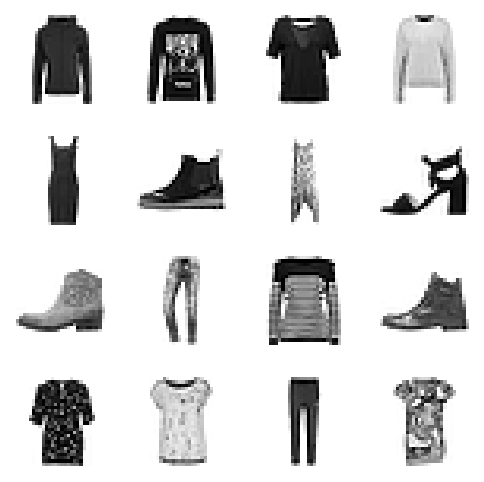

In [8]:
show_images(xb[:16], imsize=1.5)

In [9]:
betamin, betamax, n_steps = 0.0001,0.02,1000
beta = torch.linspace(betamin, betamax, n_steps)
alpha = 1. - beta
alphabar = alpha.cumprod(dim=0)
sigma = beta.sqrt()

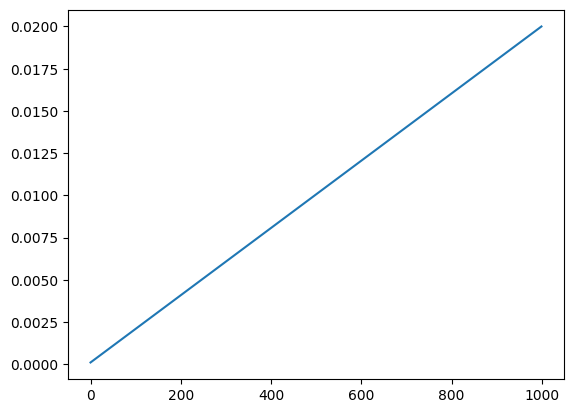

In [10]:
plt.plot(beta)

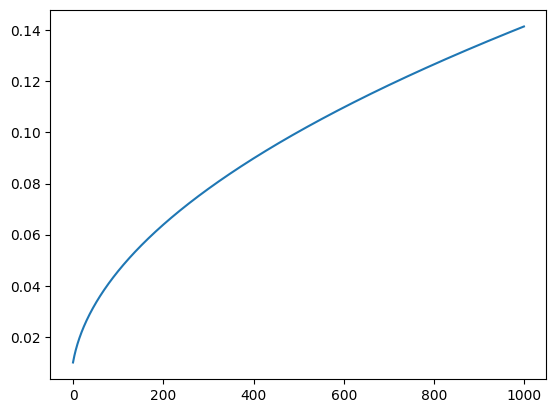

In [11]:
plt.plot(sigma)

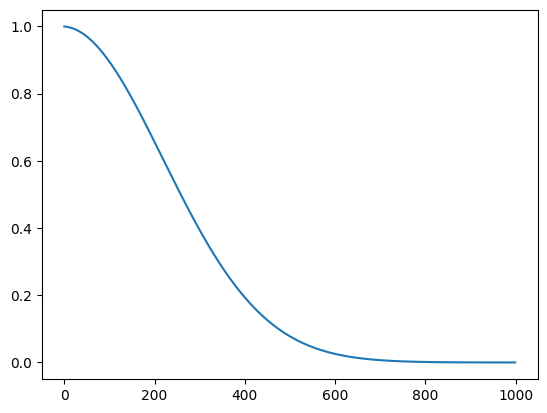

In [12]:
plt.plot(alphabar)

In [13]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n, ), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt() * x0 + (1 - ᾱ_t).sqrt() * ε
    return (xt, t.to(device)), ε

In [14]:
(xt, t), ε = noisify(xb[:25], alphabar)
t

tensor([614, 267, 775, 588, 946, 949, 762, 774,  88, 837, 839, 445, 685, 790,
        879, 164,  12, 588, 141, 544, 266, 254, 697, 404, 955])

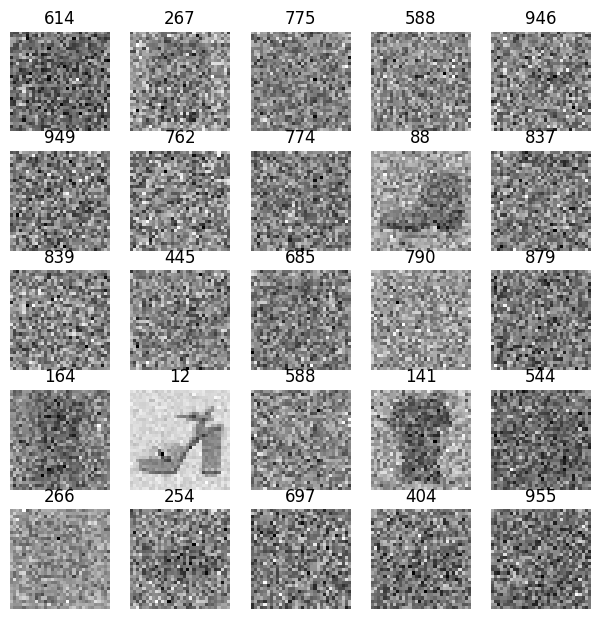

In [15]:
titles = fc.map_ex(t, '{}')
show_images(xt, imsize=1.5, titles=titles)

## Training

In [16]:
from diffusers import UNet2DModel

@torch.no_grad()
def sample(model, sz, alpha, alphabar, sigma, n_steps):
    device = next(model.parameters()).device
    x_t = torch.randn(sz, device=device)
    preds = []

    for t in reversed(range(n_steps)):
        t_batch = torch.full((x_t.shape[0],), t, device=device, dtype=torch.long)
        z = (torch.randn(x_t.shape) if t > 0 else torch.zeros(x_t.shape)).to(device)
        ᾱ_t1 = alphabar[t-1] if t > 0 else torch.tensor(1)
        b̄_t = 1 - alphabar[t]
        b̄_t1 = 1 - ᾱ_t1
        x_0_hat = ((x_t - b̄_t.sqrt() * learn.model((x_t, t_batch))) / alphabar[t].sqrt()).clamp(-1, 1)
        x_t = x_0_hat * ᾱ_t1.sqrt() * (1 - alpha[t]) / b̄_t + x_t * alpha[t].sqrt() * b̄_t1 / b̄_t + sigma[t] * z
        preds.append(x_t.cpu())
    return preds

In [17]:
class DDPMCB(Callback):
    order = DeviceCB.order + 1

    def __init__(self, n_steps, beta_min, beta_max):
        super().__init__()
        fc.store_attr()
        self.beta = torch.linspace(self.beta_min, self.beta_max, self.n_steps)
        self.α = 1. - self.beta 
        self.ᾱ = torch.cumprod(self.α, dim=0)
        self.σ = self.beta.sqrt()
    
    def before_batch(self, learn):
        learn.batch = noisify(learn.batch[0], self.ᾱ)
    
    def sample(self, model, sz):
        return sample(model, sz, self.α, self.ᾱ, self.σ, self.n_steps)

In [18]:
class UNet(UNet2DModel):
    def forward(self, x):
        return super().forward(*x).sample

In [19]:
ddpm_cb = DDPMCB(n_steps=1000, beta_min=0.0001, beta_max=0.02)

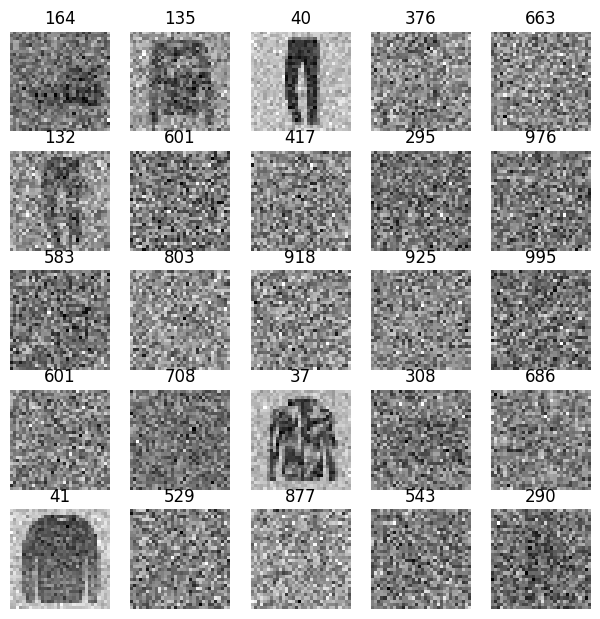

In [20]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 64), norm_num_groups=8)

learn = TrainLearner(model, dls, nn.MSELoss())
learn.fit(train=False, cbs=[ddpm_cb, SingleBatchCB()])

(xt, t), ε = learn.batch

show_images(xt[:25], titles=fc.map_ex(t[:25], '{}'), imsize=1.5)

In [21]:
lr = 5e-3
epochs = 5

tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [ddpm_cb, DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]

In [22]:
model = UNet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)

In [23]:
def init_ddpm(model):
    for o in model.down_blocks:
        for p in o.resnets:
            p.conv2.weight.data.zero_()
            for p in fc.L(o.downsamplers):
                init.orthogonal_(p.conv.weight)

    for o in model.up_blocks:
        for p in o.resnets: p.conv2.weight.data.zero_()

    model.conv_out.weight.data.zero_()

In [24]:
init_ddpm(model)

In [25]:
opt_func = partial(optim.Adam, eps=1e-5)

In [26]:
learn = TrainLearner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.148,0,train
0.027,0,eval
0.023,1,train
0.021,1,eval
0.020,2,train
0.019,2,eval
0.019,3,train
0.019,3,eval
0.018,4,train
0.019,4,eval


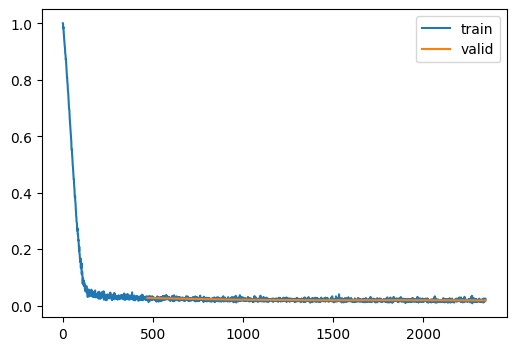

In [27]:
learn.fit(epochs)

## Sampling

In [28]:
samples = ddpm_cb.sample(learn.model, (16, 1, 32, 32))

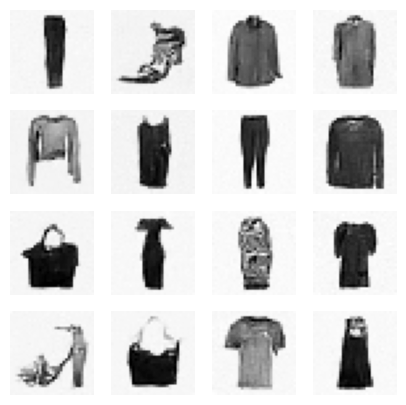

In [29]:
show_images(samples[-1], figsize=(5,5))

## Mixed Precision

In [1]:
bs = 512

In [ ]:
next(iter(DataLoader(tds['train'], batch_size=2)))

In [ ]:
def collate_ddpm(b):
    return noisify(default_collate(b)[xl], alphabar)

def dl_ddpm(ds):
    return DataLoader(ds, batch_size=bs, collate_fn=collate_ddpm, num_workers=4)

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
class MixedPrecision(TrainCB):
    order = DeviceCB.order+10
    
    def before_fit(self, learn):
        self.scaler = torch.cuda.amp.GradScaler()

    def before_batch(self, learn):
        self.autocast = torch.autocast("cuda", dtype=torch.float16)
        self.autocast.__enter__()

    def after_loss(self, learn):
        self.autocast.__exit__(None, None, None)
        
    def backward(self, learn):
        self.scaler.scale(learn.loss).backward()

    def step(self, learn):
        self.scaler.step(learn.opt)
        self.scaler.update()

In [ ]:
lr =  1e-2
epochs = 8
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), MixedPrecision(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched)]
model = Unet(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
learner = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

In [ ]:
samples = sample(learn.model, (32, 1, 32, 32), alpha, alphabar, sigma, n_steps)

In [ ]:
show_images(samples[-1][:25], imsize=1.5)

## Accelerate

`pip install accelerate` before running this section.

In [ ]:
from accelerate import Accelerator

In [ ]:
class AccelerateCB(TrainCB):

    order = DeviceCB.order+10

    def __init__(self, n_inp=1, mixed_precision="fp16"):
        super().__init__(n_inp=n_inp)
        self.acc = Accelerator(mixed_precision=mixed_precision)
        
    def before_fit(self, learner):
        learner.model, learner.opt, learner.dls.train, learner.dls.valid = self.acc.prepare(
            learner.model, learner.opt, learner.dls.train, learner.dls.valid)

    def backward(self, learn): 
        self.acc.backward(learner.loss)

In [ ]:
def noisify(x0, ᾱ):
    device = x0.device
    n = len(x0)
    t = torch.randint(0, n_steps, (n,), dtype=torch.long)
    ε = torch.randn(x0.shape, device=device)
    ᾱ_t = ᾱ[t].reshape(-1, 1, 1, 1).to(device)
    xt = ᾱ_t.sqrt()*x0 + (1-ᾱ_t).sqrt()*ε
    return xt, t.to(device), ε

In [ ]:
dls = DataLoaders(dl_ddpm(tds['train']), dl_ddpm(tds['test']))

In [ ]:
class DDPMCB2(Callback):
    def after_predict(self, learner): 
        learner.preds = learner.preds.sample

In [ ]:
model = UNet2DModel(in_channels=1, out_channels=1, block_out_channels=(16, 32, 64, 128), norm_num_groups=8)
init_ddpm(model)
cbs = [DDPMCB2(), DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), AccelerateCB(n_inp=2)]
learner = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

In [ ]:
learn.fit(epochs)

## A sneaky trick

In [1]:
class MultDL:
    def __init__(self, dl, mult=2):
        self.dl,self.mult = dl,mult
    def __len__(self):
        return len(self.dl)*self.mult
    def __iter__(self):
        for o in self.dl:
            for i in range(self.mult):
                yield o